<a href="https://www.kaggle.com/code/hannahkariuki/cnn-for-retinal-oct-images?scriptVersionId=124797593" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Convolutional Neural Networks for Classification of Retinal OCT Images

# Introduction
Retinal optical coherence tomography (OCT) is a non-invasive imaging technique used to capture high-resolution cross-sectional images of the retina at resolutions of a few microns, which allows for the visualization of individual retinal layers and structures. OCT is commonly used in the diagnosis and management of a range of retinal conditions, including macular degeneration, diabetic retinopathy, and glaucoma.

In this notebook, a custom CNN model is built for the classification of Retinal OCT images.

## Importing required libraries

In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
# Reproducability
def set_seed(seed=1234):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

### Load Data

In [3]:
train_directory = '/kaggle/input/kermany2018/OCT2017 /train'
val_directory = '/kaggle/input/kermany2018/OCT2017 /val'
test_directory = '/kaggle/input/kermany2018/OCT2017 /test'

## Preprocessing
The grayscale images were converted to 'rgb', and resized to 128 by 128 pixels

In [4]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    image_size=(112,112),
    batch_size=16,
    color_mode='rgb',
    validation_split= None,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    image_size=(112,112),
    batch_size=16,
    color_mode='rgb',
    validation_split=None,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    image_size=(112,112),
    batch_size=16,
    color_mode='rgb',
)

Found 83484 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Found 968 files belonging to 4 classes.


In [5]:
class_labels= ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [6]:
#store test labels
test_labels = [labels for _, labels in test.unbatch()]

## Exploring the Data

Check the classes in the training set

In [7]:
# Classes
class_names=train.class_names
print(class_names)

['CNV', 'DME', 'DRUSEN', 'NORMAL']


Visualize the images

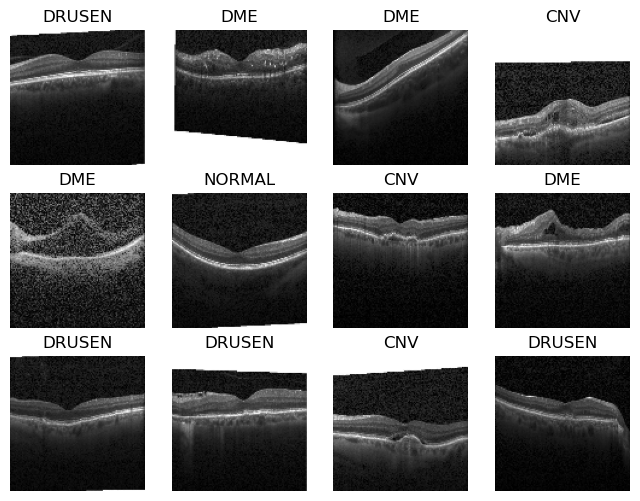

In [8]:
# visualize some of the images 
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint16"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# Determine the distribution of classes
BATCH_SIZE=16
class_names = train.class_names

def class_distribution(dataset):
    class_values = []
    total_batches = dataset.__len__().numpy()
    for batch, element in enumerate(dataset.as_numpy_iterator()):
        if batch+1 == total_batches:
            for i in range(len(element[1])):
                class_values.append(class_names[int(element[1][i])])
        else:
            for i in range(BATCH_SIZE):
                class_values.append(class_names[int(element[1][i])])

    class_n, frequency = np.unique(np.array(class_values), return_counts=True)
    #frequency = frequency/len(class_values)
    return pd.DataFrame(frequency, class_n, columns=["Count"])

train_class_dist = class_distribution(train)
print(train_class_dist)

        Count
CNV     37205
DME     11348
DRUSEN   8616
NORMAL  26315


## Correct data imbalance
The dataset suffers class imbalance which is common in real-world scenarios. Most of the images are classified as CNV. The class imbalance can bias the model towards the majority class and lead to poor performance on the minority class. To address this issue,we calculate the weight for each class to be used in training step.


In [10]:
#Calculate class weight
total = len(train.file_paths)
count_cnv = 37205
count_dme = 11348
count_drusen = 8616
count_normal = 26315
cnv_weight = (1/count_cnv) * (total/4)
dme_weight = (1/count_dme) * (total/4)
drusen_weight = (1/count_drusen) * (total/4)
norm_weight = (1/count_normal) * (total/4)
class_weight = {0 : cnv_weight, 1: dme_weight, 2 : drusen_weight, 3: norm_weight}
print(class_weight)

{0: 0.5609729875016799, 1: 1.839178709904829, 2: 2.4223537604456826, 3: 0.7931217936538096}


In [11]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (
    train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
validation = (
    validation
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test = (
    test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Define the Baseline Model

Baseline Model

## Compile and Train the Model

In [12]:
model_1 = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',input_shape=(112,112,3)),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(units=4, activation='sigmoid'),
])

In [13]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model_1.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 20,
)

Epoch 1/20
5218/5218 [==============================] - 259s 48ms/step - loss: 1.5667 - accuracy: 0.2665 - val_loss: 1.3699 - val_accuracy: 0.2812
Epoch 2/20
5218/5218 [==============================] - 50s 10ms/step - loss: 1.3822 - accuracy: 0.2312 - val_loss: 1.3866 - val_accuracy: 0.2500
Epoch 3/20
5218/5218 [==============================] - 50s 9ms/step - loss: 1.3868 - accuracy: 0.2280 - val_loss: 1.3865 - val_accuracy: 0.2500
Epoch 4/20
5218/5218 [==============================] - 49s 9ms/step - loss: 1.3883 - accuracy: 0.2243 - val_loss: 1.3865 - val_accuracy: 0.2500
Epoch 5/20
5218/5218 [==============================] - 50s 10ms/step - loss: 1.3872 - accuracy: 0.2141 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 6/20
5218/5218 [==============================] - 50s 10ms/step - loss: 1.3865 - accuracy: 0.2337 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 7/20
5218/5218 [==============================] - 50s 10ms/step - loss: 1.3864 - accuracy: 0.2297 - val_loss: 1.3863 - 

## Performancce Plot

Best Validation Loss: 1.3699
Best Validation Accuracy: 0.2812


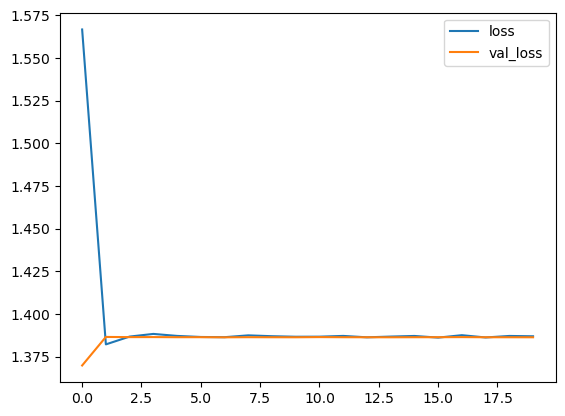

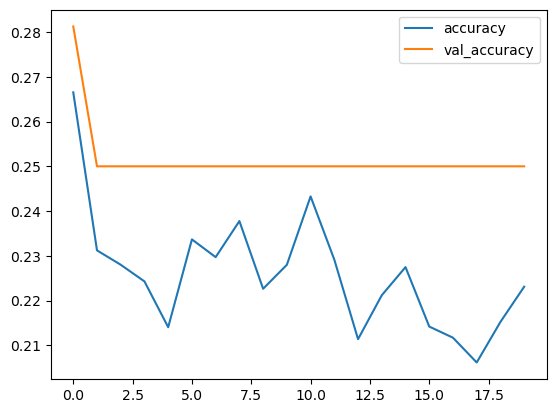

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

The model is overfitting. Various methods can be applied to correct overfitting; 
* Adding regularization layers(Dropout layer, BatchNormalization) 
* Data augmentation

## Define Model

In [15]:
#Adding Batch Normalization
model=Sequential([
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(112,112,3)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=4, activation='sigmoid')
])

## Compile and Train Model

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 20,
    callbacks=[early_stopping]
)

Epoch 1/20
5218/5218 [==============================] - 60s 11ms/step - loss: 0.6975 - accuracy: 0.7477 - val_loss: 0.1412 - val_accuracy: 0.9688
Epoch 2/20
5218/5218 [==============================] - 55s 11ms/step - loss: 0.3584 - accuracy: 0.8777 - val_loss: 0.2879 - val_accuracy: 0.9062
Epoch 3/20
5218/5218 [==============================] - 55s 11ms/step - loss: 0.2622 - accuracy: 0.9102 - val_loss: 0.0288 - val_accuracy: 1.0000
Epoch 4/20
5218/5218 [==============================] - 55s 11ms/step - loss: 0.1885 - accuracy: 0.9348 - val_loss: 0.0623 - val_accuracy: 0.9688
Epoch 5/20
5218/5218 [==============================] - 56s 11ms/step - loss: 0.1365 - accuracy: 0.9529 - val_loss: 0.0361 - val_accuracy: 1.0000
Epoch 6/20
5218/5218 [==============================] - 55s 11ms/step - loss: 0.1015 - accuracy: 0.9635 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/20
5218/5218 [==============================] - 55s 10ms/step - loss: 0.0737 - accuracy: 0.9739 - val_loss: 0.0074 -

## Train the Model

## Performance Plot

Best Validation Loss: 0.0021
Best Validation Accuracy: 1.0000


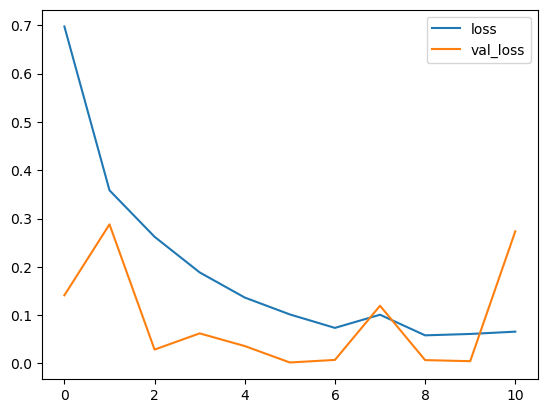

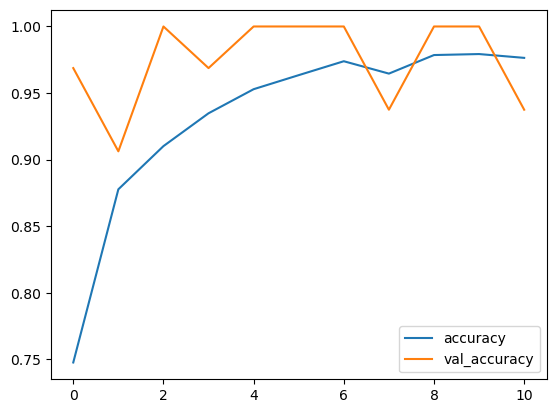

In [17]:
acc = history.history['accuracy']
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

## Predict and Evaluate Results

In [18]:
model.evaluate(test, return_dict=True)

61/61 [==============================] - 3s 47ms/step - loss: 0.0543 - accuracy: 0.9783


{'loss': 0.054294995963573456, 'accuracy': 0.9783057570457458}

In [19]:
predictions = model.predict(test)
#Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

61/61 [==============================] - 0s 3ms/step


In [20]:
print(classification_report(test_labels, predictions, target_names=class_labels))

              precision    recall  f1-score   support

         CNV       0.26      0.24      0.25       242
         DME       0.24      0.25      0.25       242
      DRUSEN       0.26      0.26      0.26       242
      NORMAL       0.22      0.22      0.22       242

    accuracy                           0.24       968
   macro avg       0.25      0.24      0.24       968
weighted avg       0.25      0.24      0.24       968



### Conclusion
The Validation set is quite small, therefore, the evaluation metrics; accuracy, precision, recall, and F1 score have large variance and could not lead to the proper tuning of the model.
Next steps;
* Use a larger Validation set
* Hyperparameter tuning
* Data Augmentation
* Transfer Learning